# This is notebook mainly shows the methods about halos rendering 

Including:

### Initializing the Halos Pipeline
This section initializes the `HalosSkyPyPipeline` with specified parameters such as sky area and mass range. The pipeline is prepared for halo generation and mass sheet correction calculations. After initialization, the halos generated by the pipeline are displayed, and a scatter plot of redshift (`z`) versus the logarithm of the mass (`log10(mass)`) for the halos is plotted.

### Plotting the Convergence Map for the Halos
This section focuses on plotting the convergence map for the halos, both with and without mass sheet correction. The convergence map visualizes the impact of the mass distribution on light bending, an essential aspect of gravitational lensing studies.

### Render the Joint Contribution of External Convergence and Shears from Halos Rendering
Here, we render the joint contribution of external convergence and shears resulting from halos rendering. This analysis helps in understanding the combined effect of multiple halos on the gravitational lensing signal.

### Combine the Halos and Glass Data
This section combines the halos data with glass data. The glass data typically represents a random field that mimics the underlying mass distribution in the universe, and combining it with halos data provides a comprehensive view of the mass distribution.

### Plotting the Joint Distribution of Kappa and Gamma (specific redshifts)
Finally, this section plots the joint distribution of kappa and gamma, both with and without non-linear correction. Kappa represents the convergence, while gamma represents the shear. Analyzing their joint distribution helps in understanding the overall effect of lensing by the mass distribution, including both linear and non-linear contributions.

In [12]:
from slsim.Pipelines.halos_pipeline import HalosSkyPyPipeline
from slsim.Halos.halos_lens_base import HalosLensBase
import numpy as np
from astropy.cosmology import default_cosmology, FlatLambdaCDM
import matplotlib.pyplot as plt
from slsim.Halos.halos_plus_glass import (
    read_glass_data,
    skyarea_form_n,
    generate_samples_from_glass,
    halos_plus_glass,
    convergence_mean_0,
    run_certain_redshift_lensext_kde_by_multiprocessing,
)
import os
from slsim.Halos.halos_plus_glass import run_halos_without_kde_by_multiprocessing
import seaborn as sns
import pandas as pd

# Initializing the Halos Pipeline
Initializes the 'HalosSkyPyPipeline' with specified parameters like sky area and mass range, preparing the pipeline for halo generation and mass sheet correction calculations.
Shows the halos generated by the pipeline and plots a scatter plot of z vs. log10(mass) for the halos.

         z                 mass       
------------------- ------------------
 2.2098687156829717  375236378458.5145
  1.745836274035676  427241815809.0078
 0.6448066631054133 290649315458.26935
0.12414649240878566  387823667606.1633
 1.2202583925591661 238351562762.69803
 1.2490788803084298  244017518509.6967
  2.911714972719506 207581919029.53467
 2.5433514923102005  432243533562.2961
  4.296342980899122  296802196525.5437
 0.5717861572598528  244915056845.1267
                ...                ...
  2.227480845645767  287694687592.0098
 0.8272253679321437  587499163120.2087
  4.148953902573391  215664149269.6096
 0.7187544659647216  495666641430.8711
 2.9216558571839606  314834519636.4046
   1.00554567032282  314645760019.4325
  1.131899337166691 272838941621.89505
 3.8266450320533996 343378280872.59045
 1.4614645409575986 1290612810404.1653
 1.4457041085441396  414614391180.1287
 2.1601157559765043  565941928012.0226
Length = 84 rows


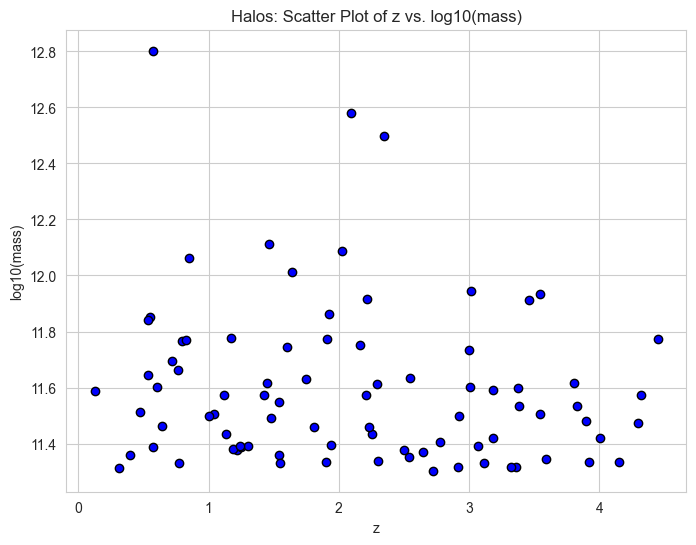

In [13]:
pipeline = HalosSkyPyPipeline(
    sky_area=0.00036,  # in square degrees
    m_max="1.0E+16",  # in solar masses
    m_min="2.0E+11",
    z_max=5.00,
)
halos = pipeline.halos
mass_sheet_correction = (
    pipeline.mass_sheet_correction
)  # calculating a negative convergence for
# mass sheet based on the average convergence of multiple halos rendering

print(halos)
z_halos = halos["z"]
mass_halos = halos["mass"]

log_mass = np.log10(mass_halos)
plt.figure(figsize=(8, 6))
plt.scatter(z_halos, log_mass, c="blue", marker="o", edgecolors="black")
plt.title("Halos: Scatter Plot of z vs. log10(mass)")
plt.xlabel("z")
plt.ylabel("log10(mass)")
plt.grid(True)

# Plotting the convergence map for the halos
## with or without mass sheet correction

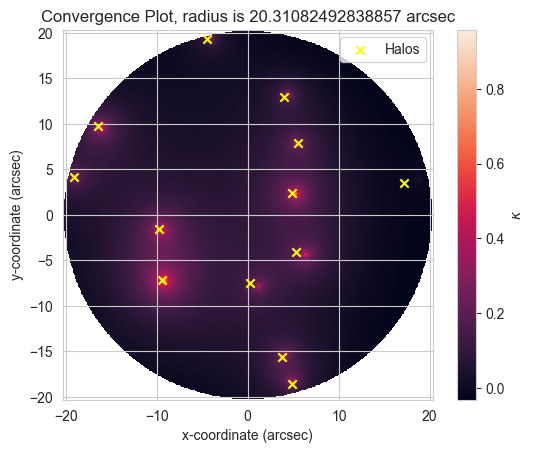

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLensBase(
    halos_list=halos,
    mass_correction_list=mass_sheet_correction,
    mass_sheet=True,
    sky_area=0.0001,
    cosmo=cosmo,
)
halos_lens.plot_halos_convergence(
    diff=0.01,
)

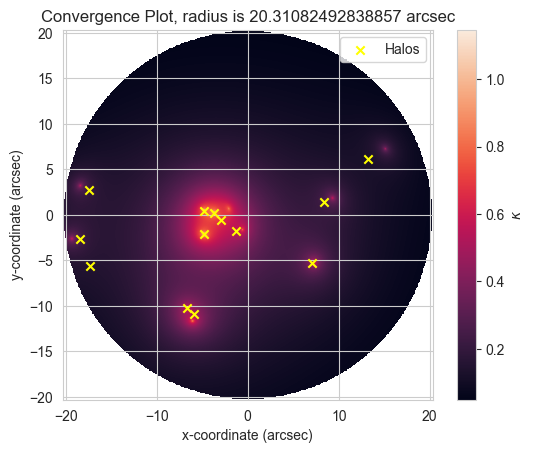

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLensBase(
    halos_list=halos,
    mass_correction_list=None,  # No mass sheet correction
    mass_sheet=False,  # No mass sheet correction
    sky_area=0.0001,
    cosmo=cosmo,
)
halos_lens.plot_halos_convergence(diff=0.01)

## Render the joint contribution of external convergence and shears from halos rendering

In [5]:
halos_k, halos_g = run_halos_without_kde_by_multiprocessing(
    n_iterations=100,
    sky_area=0.00036,
    samples_number=100,
    cosmo=cosmo,
    z_max=5.0,
)

kappa_random_halos = convergence_mean_0(halos_k)
gamma_random_halos = halos_g

The 100 halo-lists took 13.750079870223999 seconds to run


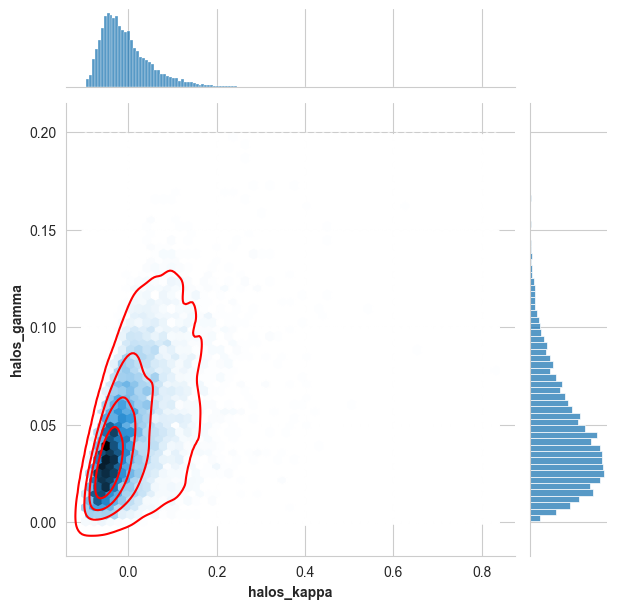

In [6]:
total_plot = sns.jointplot(x=kappa_random_halos, y=gamma_random_halos, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("halos_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("halos_gamma", fontweight="bold")
plt.show()

## Combine the halos and glass data

In [7]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
slsim_directory = os.path.dirname(parent_directory)
file_path = os.path.join(parent_directory, "tests/TestData/kgdata.npy")

In [8]:
kappa_values, gamma_values, nside = read_glass_data(file_name=file_path)
skyarea = skyarea_form_n(nside)
kappa_random_glass, gamma_random_glass = generate_samples_from_glass(
    kappa_values, gamma_values, n=5000
)
print(kappa_random_glass.shape, gamma_random_glass.shape)

(5000,) (5000,)


In [9]:
total_kappa, total_gamma = halos_plus_glass(
    kappa_random_glass, gamma_random_glass, kappa_random_halos, gamma_random_halos
)

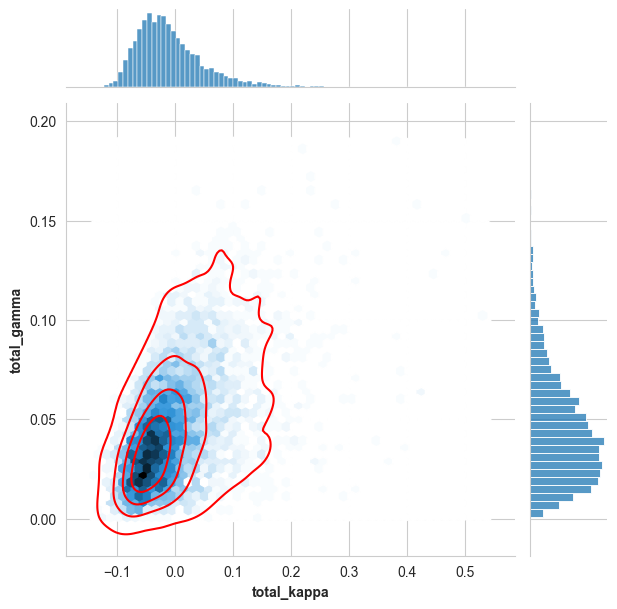

In [10]:
total_plot = sns.jointplot(x=total_kappa, y=total_gamma, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("total_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("total_gamma", fontweight="bold")
plt.show()

# Plotting the joint distribution of kappa and gamma
## with and without non-linear correction


In [14]:
def plot_kappa_gamma(
    zs=1.5,
    zd=0.5,
    n_iterations=300,
    sky_area=0.00036,
    samples_number=30,
    m_min="1.0E+12",
    m_max="1.0E+16",
):
    # Setup Cosmology
    cosmo = default_cosmology.get()
    # Without Correction
    nk, ng = run_halos_without_kde_by_multiprocessing(
        n_iterations=n_iterations,
        sky_area=sky_area,
        samples_number=samples_number,
        cosmo=cosmo,
        m_min=m_min,
        m_max=m_max,
        z_max=zs,
        listmean=False,
    )
    nk_mean = sum(nk) / len(nk)
    print(f"zs={zs}, zd={zd},k_s_mean={nk_mean}")
    nk = convergence_mean_0(nk)

    # With Correction
    distribution = run_certain_redshift_lensext_kde_by_multiprocessing(
        n_iterations=n_iterations,
        sky_area=sky_area,
        samples_number=samples_number,
        cosmo=cosmo,
        m_min=m_min,
        m_max=m_max,
        z_max=zs,
        zs=zs,
        zd=zd,
        listmean=False,
    )
    nk1 = [point[0] for point in distribution]
    ng1 = [point[1] for point in distribution]
    nk1_mean = sum(nk1) / len(nk1)
    print(f"zs={zs}, zd={zd},k_ext_mean={nk1_mean}")
    nk1 = convergence_mean_0(nk1)

    # Combine Data for Joint KDE Plot
    df1 = pd.DataFrame({"x": nk, "y": ng, "type": "Without non-linear Correction"})
    df2 = pd.DataFrame({"x": nk1, "y": ng1, "type": "With non-linear Correction"})
    df_total = pd.concat([df1, df2], axis=0)

    var_nk = np.var(nk)
    var_nk1 = np.var(nk1)
    print(f"Variance of k_S: {var_nk}")
    print(f"Variance of k_ext: {var_nk1}")

    # Plotting
    plot = sns.jointplot(data=df_total, x="x", y="y", hue="type", kind="kde")

    plot.ax_joint.set_xlabel("kappa")
    plot.ax_joint.set_ylabel("gamma")
    m_min_float = float(m_min)
    plt.title(f"zs={zs}, zd={zd}, mean=0")
    plot.fig.suptitle(
        f"zs={zs}, zd={zd}, m=10^{np.log10(m_min_float)}, mean=0, with mass-sheet"
    )
    plot.ax_joint.set_xlim(-0.1, 0.2)
    plot.ax_joint.set_ylim(-0.01, 0.08)

    plt.show()


# To use the function:
#plot_kappa_gamma(zs=1.5, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
#plot_kappa_gamma(zs=2.5, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
#plot_kappa_gamma(zs=2.0, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
#plot_kappa_gamma(zs=1.0, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")

The 300 halo-lists took 53.0202579498291 seconds to run
zs=5.0, zd=0.5,k_s_mean=0.08502018560707901
The 300 halo-lists took 137.4075801372528 seconds to run
zs=5.0, zd=0.5,k_ext_mean=0.016167228945683437
Variance of k_S: 0.005689447649428736
Variance of k_ext: 0.002777644059162038


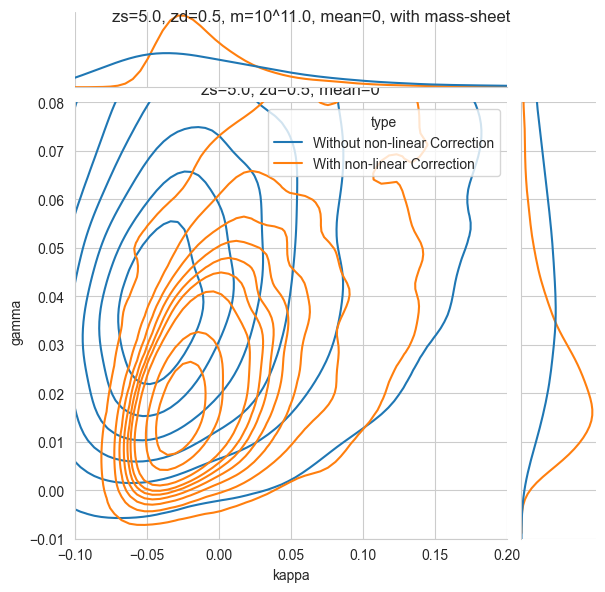

The 300 halo-lists took 54.85426616668701 seconds to run
zs=5.0, zd=1.5,k_s_mean=0.08901602269133116
The 300 halo-lists took 134.68123698234558 seconds to run
zs=5.0, zd=1.5,k_ext_mean=0.049794610876069276
Variance of k_S: 0.0061137246682996535
Variance of k_ext: 0.00788250155143504


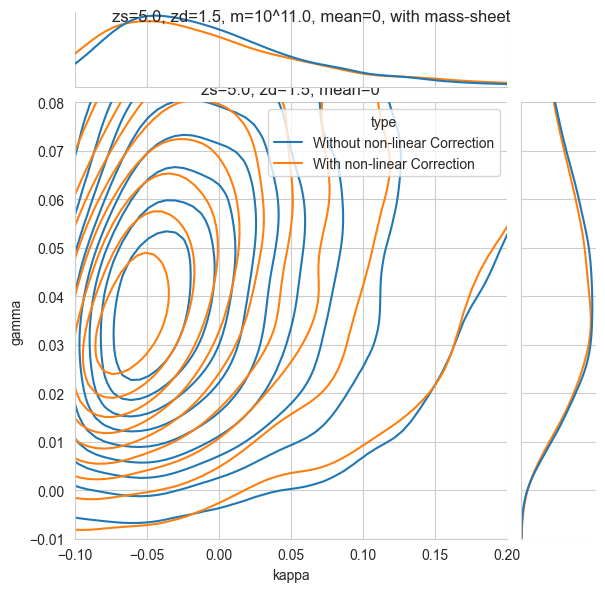

The 300 halo-lists took 53.88901400566101 seconds to run
zs=5.0, zd=2.5,k_s_mean=0.08723808086190857
The 300 halo-lists took 137.7633650302887 seconds to run
zs=5.0, zd=2.5,k_ext_mean=0.08972404703400831
Variance of k_S: 0.00566260417818973
Variance of k_ext: 0.012643830745532518


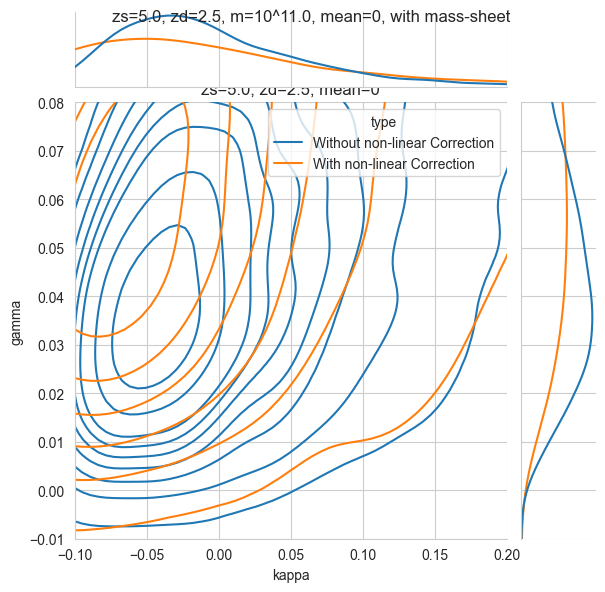

The 300 halo-lists took 55.34009385108948 seconds to run
zs=5.0, zd=3.5,k_s_mean=0.08558835906816871
The 300 halo-lists took 137.48514890670776 seconds to run
zs=5.0, zd=3.5,k_ext_mean=0.10824934096396004
Variance of k_S: 0.005916763850640052
Variance of k_ext: 0.01465305887904757


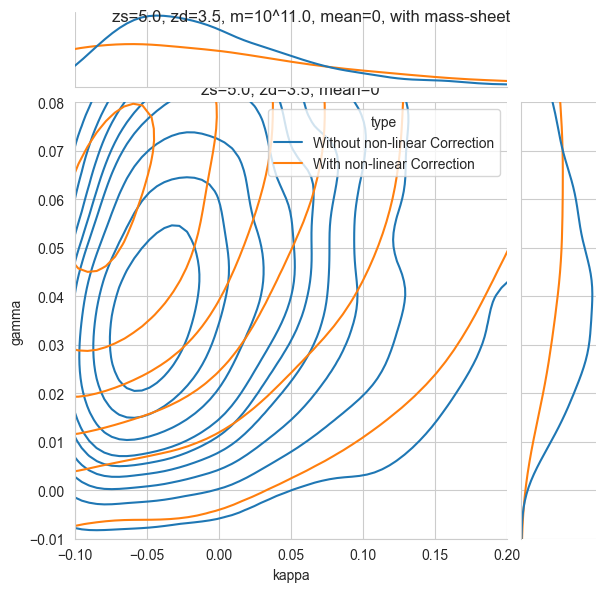

The 300 halo-lists took 56.49216914176941 seconds to run
zs=5.0, zd=4.5,k_s_mean=0.09142614926540932
The 300 halo-lists took 140.70462775230408 seconds to run
zs=5.0, zd=4.5,k_ext_mean=0.14485350661016086
Variance of k_S: 0.0059657584682013655
Variance of k_ext: 0.015750958582361873


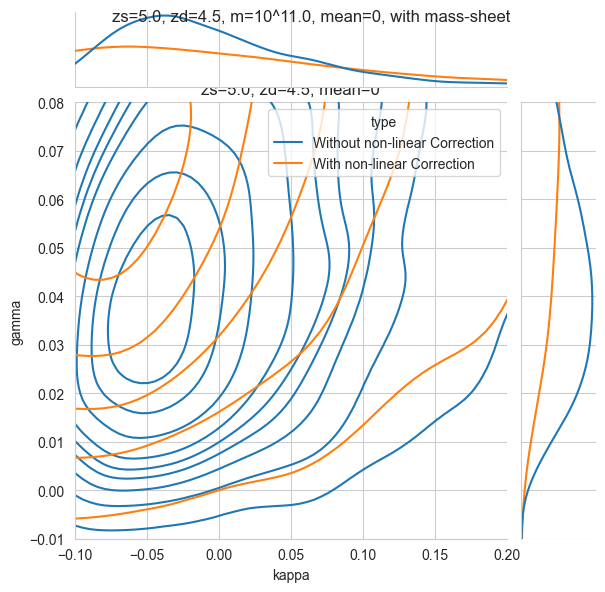

In [15]:
plot_kappa_gamma(zs=5.0, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=5.0, zd=1.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=5.0, zd=2.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=5.0, zd=3.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=5.0, zd=4.5, m_min="1.0E+11", m_max="1.0E+16")
